In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

%matplotlib inline

## Preparing the Dataset

In [83]:
def get_data(file_path, remote_path):
    if not file_path.is_file():
        !wget $remote_path
    return pd.read_csv(file_path)

In [84]:
file_path = Path('car_fuel_efficiency.csv')
data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"
df = get_data(file_path, data)
df = df[['engine_displacement', 'horsepower', 'vehicle_weight','model_year', 'fuel_efficiency_mpg' ]]
df.head()


,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


## Exploratory Data Analysis¶

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

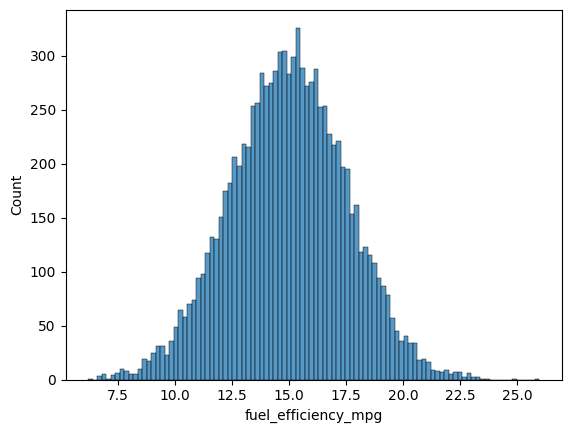

In [85]:
sns.histplot(df.fuel_efficiency_mpg, bins= 100)

In [86]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [87]:
percentiles = df['horsepower'].quantile([0.1, 0.25, 0.5, 0.75, 0.9])
print(percentiles)

0.10    111.0
0.25    130.0
0.50    149.0
0.75    170.0
0.90    188.0
Name: horsepower, dtype: float64


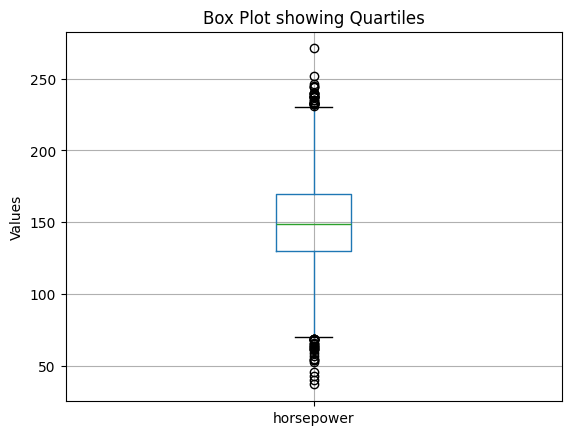

In [88]:
df.boxplot(column='horsepower')
plt.title('Box Plot showing Quartiles')
plt.ylabel('Values')
plt.show()

## Prepare and split the dataset

In [89]:
def dot(x1,w):
    return sum(xi * wi for xi, wi in zip(x1, w))

In [112]:
def train_linear_regression(X,Y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])  # NO .round() here!
    
    XTX = X.T.dot(X)
    
    # Add regularization for numerical stability
    reg = 0.001
    XTX = XTX + reg * np.eye(XTX.shape[0])
    
    # Use regular inverse (more stable than pinv in this case)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(Y)
    
    return w_full[0], w_full[1:]

In [113]:
def rmse(y, y_pred):
    se = (y - y_pred) **2
    mse = se.mean()
    return np.sqrt(mse)

In [114]:
n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]
len(df_train), len(df_val), len(df_test)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_train_mean = df_train.copy()
df_train_mean['horsepower'] = df_train_mean['horsepower'].fillna(
    df_train_mean['horsepower'].median(numeric_only=True)
)
y_train_mean = np.log1p(df_train_mean.fuel_efficiency_mpg.values)

df_train_zeros = df_train.copy()
df_train_zeros['horsepower'] = df_train_zeros['horsepower'].fillna(0)
y_train = np.log1p(df_train_zeros.fuel_efficiency_mpg.values)
y_val = np.log1p(df_val.fuel_efficiency_mpg.values)
y_test = np.log1p(df_test.fuel_efficiency_mpg.values)

del df_train_zeros['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']
del df_train_mean['fuel_efficiency_mpg']

In [115]:
X_train = df_train_zeros.values
w0, w = train_linear_regression(X_train,y_train)
y_pred = w0 + X_train.dot(w)
rmse_zeros = rmse(y_train, y_pred)

In [116]:

X_train_mean = df_train_mean.values
w0, w = train_linear_regression(X_train_mean,y_train_mean)
y_pred_mean = w0 + X_train_mean.dot(w)
rmse_mean = rmse(y_train_mean, y_pred_mean)

In [117]:
print(f'RMSE Mean: {rmse_mean}')
print(f'RMSE ZEROS: {rmse_zeros}')

RMSE Mean: 0.035813022816366356
RMSE ZEROS: 0.039086772858531973


## Regularization

In [118]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones,X])

    XTX = X.T.dot(X)
    XTX = XTX + r*np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [119]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w0,w = train_linear_regression_reg(X_train, y_train, r=r)
    X_val = df_val.copy()
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    print( r, w0, score)

0 3.6646662472218297 0.03915910132510417
0.01 3.1688134470074534 0.03915544012795345
0.1 1.4288369989383432 0.03968901439911248
1 0.22012861946726972 0.04054510963213077
5 0.04624885656570121 0.04069949625768189
10 0.023271722731248758 0.040720468852610416
100 0.0023413689852701753 0.040739692003913586


In [120]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [122]:
def train_linear_regression(X, Y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])  # NO .round() here!
    
    XTX = X.T.dot(X)
    
    # Add regularization for numerical stability
    reg = 0.001
    XTX = XTX + reg * np.eye(XTX.shape[0])
    
    # Use regular inverse (more stable than pinv in this case)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(Y)
    
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

# Prepare the data
df_processed = df[['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']].copy()
df_processed['horsepower'] = df_processed['horsepower'].fillna(0)

n = len(df_processed)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_scores = []

for seed in seeds:
    # Shuffle with current seed
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)
    
    # Split data
    df_train = df_processed.iloc[idx[:n_train]].copy().reset_index(drop=True)
    df_val = df_processed.iloc[idx[n_train:n_train+n_val]].copy().reset_index(drop=True)
    
    # Prepare target variables
    y_train = np.log1p(df_train['fuel_efficiency_mpg'].values)
    y_val = np.log1p(df_val['fuel_efficiency_mpg'].values)
    
    # Prepare features
    X_train = df_train.drop('fuel_efficiency_mpg', axis=1).values
    X_val = df_val.drop('fuel_efficiency_mpg', axis=1).values
    
    # Train model
    w0, w = train_linear_regression(X_train, y_train)
    
    # Predict on validation set
    y_pred = w0 + X_val.dot(w)
    
    # Calculate RMSE
    score = rmse(y_val, y_pred)
    rmse_scores.append(score)
    print(f"Seed {seed}: RMSE = {score:.6f}")

# Calculate standard deviation
std = np.std(rmse_scores)
print(f"\nAll RMSE scores: {[round(s, 6) for s in rmse_scores]}")
print(f"Mean RMSE: {np.mean(rmse_scores):.6f}")
print(f"Standard deviation: {round(std, 3)}")

Seed 0: RMSE = 0.038016
Seed 1: RMSE = 0.039273
Seed 2: RMSE = 0.039451
Seed 3: RMSE = 0.038724
Seed 4: RMSE = 0.037280
Seed 5: RMSE = 0.039389
Seed 6: RMSE = 0.038912
Seed 7: RMSE = 0.038383
Seed 8: RMSE = 0.040198
Seed 9: RMSE = 0.038607

All RMSE scores: [np.float64(0.038016), np.float64(0.039273), np.float64(0.039451), np.float64(0.038724), np.float64(0.03728), np.float64(0.039389), np.float64(0.038912), np.float64(0.038383), np.float64(0.040198), np.float64(0.038607)]
Mean RMSE: 0.038823
Standard deviation: 0.001


In [126]:
import numpy as np
import pandas as pd

def train_linear_regression_reg(X, Y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(Y)
    
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

# Prepare the data
df_processed = df[['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']].copy()
df_processed['horsepower'] = df_processed['horsepower'].fillna(0)

n = len(df_processed)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

# Use seed 9
seed = 9
idx = np.arange(n)
np.random.seed(seed)
np.random.shuffle(idx)

# Split data
df_train = df_processed.iloc[idx[:n_train]].copy().reset_index(drop=True)
df_val = df_processed.iloc[idx[n_train:n_train+n_val]].copy().reset_index(drop=True)
df_test = df_processed.iloc[idx[n_train+n_val:]].copy().reset_index(drop=True)

# Combine train and validation datasets
df_train_val = pd.concat([df_train, df_val], ignore_index=True)

# Prepare combined train+val data
y_train_val = np.log1p(df_train_val['fuel_efficiency_mpg'].values)
X_train_val = df_train_val.drop('fuel_efficiency_mpg', axis=1).values

# Prepare test data
y_test = np.log1p(df_test['fuel_efficiency_mpg'].values)
X_test = df_test.drop('fuel_efficiency_mpg', axis=1).values

# Train model with r=0.001
w0, w = train_linear_regression_reg(X_train_val, y_train_val, r=0.001)

# Predict on TEST set
y_pred_log = w0 + X_test.dot(w)

# Calculate RMSE in log space
test_rmse_log = rmse(y_test, y_pred_log)

# Calculate RMSE in original space (transform back)
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred_log)
test_rmse_original = rmse(y_test_original, y_pred_original)

print(f"Training on: {len(df_train_val)} samples (train + validation combined)")
print(f"Testing on: {len(df_test)} samples")
print(f"\nRMSE on test dataset (log space): {test_rmse_log:.6f}")
print(f"RMSE on test dataset (original space): {test_rmse_original:.6f}")
print(f"\nRounded to 3 decimals:")
print(f"  Log space: {round(test_rmse_log, 3)}")
print(f"  Original space: {round(test_rmse_original, 3)}")



Training on: 7764 samples (train + validation combined)
Testing on: 1940 samples

RMSE on test dataset (log space): 0.039196
RMSE on test dataset (original space): 0.607386

Rounded to 3 decimals:
  Log space: 0.039
  Original space: 0.607
